<a href="https://colab.research.google.com/github/AbeerBibi/Prediction-of-Product-Sales/blob/main/Core_Project_1_Part_8_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#(Core) Project 1 - Part 8
##Task
For this assignment, you will revisit your models to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions. Then you will update your README with these insights.




---



#Import libraries, call evaluation function, load the data

In [2]:
## Our standard import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [5]:
# Load data directly from url
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
# check for null values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
#check the inconsistencies in the categorical columns
for column in df.select_dtypes(include='object').columns:
    print(column, df[column].unique())

Item_Identifier ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [8]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

#LinearRegression
- Extract and visualize the coefficients that your model determined.
- Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file to upload to your README on GitHub  (you will need this for the final piece of this assignment - Update Your README).

###Build a linear regression model.

In [9]:
## Separate features vs target & train/test split
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df['Item_Outlet_Sales']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [10]:
# Numeric
num_cols = X_train.select_dtypes("number").columns
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_mean, scaler)
num_tuple = ('numeric', num_pipe, num_cols)



In [11]:
# Ordinal
ordinal_cols=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']
impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')
ordinals_order_fat_content= ['Low Fat', 'Regular']
ordinals_order_outlet_size=['NA', 'Small', 'Medium', 'High']
ordinals_order_outlet_location_type=['Tier 1', 'Tier 2', 'Tier 3']
ordinal_category_orders=[ordinals_order_fat_content, ordinals_order_outlet_size, ordinals_order_outlet_location_type]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ordinal_cols)

In [12]:
# Nominal
ohe_cols = X_train.select_dtypes('object').drop(columns=ordinal_cols).columns
impute_na = SimpleImputer(strategy='constant', fill_value="NA")
ohe_encoder = OneHotEncoder(drop = 'first', sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

In [13]:
 # Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEn...
                                 ['Item_Fat_Content', 'Outlet_Size',
                                  'Outlet_Location_Type']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [14]:
# Instantiate a linear regression model
linreg = LinearRegression()
# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                   'Outlet_Location_Type']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [15]:
# Fit the model pipeline on the training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                   'Outlet_Location_Type']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [16]:
#get feature names and save the X data to dataframes:
# Extracting Regression Coefficients
feature_names = linreg_pipe[0].get_feature_names_out()
coeffs = pd.Series(linreg_pipe[-1].coef_, index=feature_names)
coeffs

Item_Weight                          -8.186752
Item_Visibility                     -21.646473
Item_MRP                            984.513074
Outlet_Establishment_Year           286.337528
Item_Fat_Content                     29.948654
Outlet_Size                         605.983271
Outlet_Location_Type               -119.335416
Item_Type_Breads                    -28.648318
Item_Type_Breakfast                  45.361064
Item_Type_Canned                     27.516194
Item_Type_Dairy                    -106.335014
Item_Type_Frozen Foods               -1.770626
Item_Type_Fruits and Vegetables      45.754029
Item_Type_Hard Drinks                13.894899
Item_Type_Health and Hygiene         27.025414
Item_Type_Household                   5.509746
Item_Type_Meat                      -11.864887
Item_Type_Others                    -26.813726
Item_Type_Seafood                   327.501136
Item_Type_Snack Foods               -21.932393
Item_Type_Soft Drinks               -39.485735
Item_Type_Sta

###Use the custom evaluation function to get the metrics for your model (on training and test data).

In [17]:
# Obtain Model Evulation using custom function
evaluate_regression(linreg_pipe, X_train, y_train, X_test,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.129
- MSE = 1,297,558.136
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.120
- MSE = 1,194,349.715
- RMSE = 1,092.863
- R^2 = 0.567


In [18]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False,
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [19]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs

Item_Weight                          -8.19
Item_Visibility                     -21.65
Item_MRP                            984.51
Outlet_Establishment_Year           286.34
Item_Fat_Content                     29.95
Outlet_Size                         605.98
Outlet_Location_Type               -119.34
Item_Type_Breads                    -28.65
Item_Type_Breakfast                  45.36
Item_Type_Canned                     27.52
Item_Type_Dairy                    -106.34
Item_Type_Frozen Foods               -1.77
Item_Type_Fruits and Vegetables      45.75
Item_Type_Hard Drinks                13.89
Item_Type_Health and Hygiene         27.03
Item_Type_Household                   5.51
Item_Type_Meat                      -11.86
Item_Type_Others                    -26.81
Item_Type_Seafood                   327.50
Item_Type_Snack Foods               -21.93
Item_Type_Soft Drinks               -39.49
Item_Type_Starchy Foods              42.09
Outlet_Identifier_OUT013           -361.96
Outlet_Iden

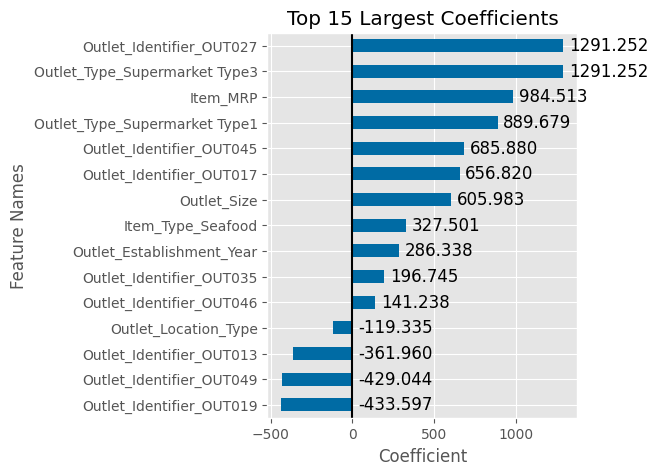

In [20]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

- The 3 largest coefficients are for:
    - "Outlet_Identifier_OUT027"- for every 1 point increase in the standard deviation of it, the predicted Item_Outlet_Sales increases 1291.252
    - "Outlet_Type_Supwemarket Type3"- for every 1 point increase in the standard deviation of it, the predicted Item_Outlet_Sales increases 1291.252
    - "Item_MRP"- for every 1 point increase in the standard deviation of it, the predicted Item_Outlet_Sales increases 984.513

#Tree-Based Model
- Extract and visualize the feature importances that your best model determined.
- Identify the top 5 most important features.
- Save your figure as a .png file to upload to your README on GitHub (you will need this for the final piece of this assignment - Update Your README).

###Build a default Random Forest model.

In [21]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state=SEED)
# Model Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=321))])

In [22]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):

    ## checking for feature names
    if feature_names == None:
        feature_names = model[0].get_feature_names_out()

    ## Saving the feature importances
    importances = pd.Series(model[-1].feature_importances_, index= feature_names,
                           name=name)

    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [23]:
# test our function
importances = get_importances(rf_pipe, sort=True,ascending=False)
importances

Item_MRP                          0.44
Item_Visibility                   0.10
Outlet_Type_Supermarket Type1     0.09
Item_Weight                       0.06
Outlet_Type_Supermarket Type3     0.06
Outlet_Identifier_OUT027          0.05
Outlet_Establishment_Year         0.03
Outlet_Identifier_OUT018          0.02
Outlet_Type_Supermarket Type2     0.02
Outlet_Size                       0.02
Item_Fat_Content                  0.01
Item_Type_Snack Foods             0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Dairy                   0.01
Item_Type_Household               0.01
Item_Type_Frozen Foods            0.01
Item_Type_Soft Drinks             0.01
Outlet_Location_Type              0.01
Outlet_Identifier_OUT035          0.01
Item_Type_Canned                  0.00
Outlet_Identifier_OUT019          0.00
Outlet_Identifier_OUT046          0.00
Outlet_Identifier_OUT045          0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Meat                    0.00
Item_Type_Starchy Foods  

###Use the custom evaluation function to get the metrics for your model (on training and test data).

In [25]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 297.586
- MSE = 184,083.598
- RMSE = 429.050
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 775.172
- MSE = 1,236,957.468
- RMSE = 1,112.186
- R^2 = 0.552


In [30]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [31]:
colors_top7 = get_color_dict(importances, top_n=7)
colors_top7

{'Item_Weight': 'green',
 'Item_Visibility': 'green',
 'Item_MRP': 'green',
 'Outlet_Establishment_Year': 'green',
 'Item_Fat_Content': '#006ba4',
 'Outlet_Size': '#006ba4',
 'Outlet_Location_Type': '#006ba4',
 'Item_Type_Breads': '#006ba4',
 'Item_Type_Breakfast': '#006ba4',
 'Item_Type_Canned': '#006ba4',
 'Item_Type_Dairy': '#006ba4',
 'Item_Type_Frozen Foods': '#006ba4',
 'Item_Type_Fruits and Vegetables': '#006ba4',
 'Item_Type_Hard Drinks': '#006ba4',
 'Item_Type_Health and Hygiene': '#006ba4',
 'Item_Type_Household': '#006ba4',
 'Item_Type_Meat': '#006ba4',
 'Item_Type_Others': '#006ba4',
 'Item_Type_Seafood': '#006ba4',
 'Item_Type_Snack Foods': '#006ba4',
 'Item_Type_Soft Drinks': '#006ba4',
 'Item_Type_Starchy Foods': '#006ba4',
 'Outlet_Identifier_OUT013': '#006ba4',
 'Outlet_Identifier_OUT017': '#006ba4',
 'Outlet_Identifier_OUT018': '#006ba4',
 'Outlet_Identifier_OUT019': '#006ba4',
 'Outlet_Identifier_OUT027': 'green',
 'Outlet_Identifier_OUT035': '#006ba4',
 'Outlet_Iden

In [32]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6),
                          color_dict=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

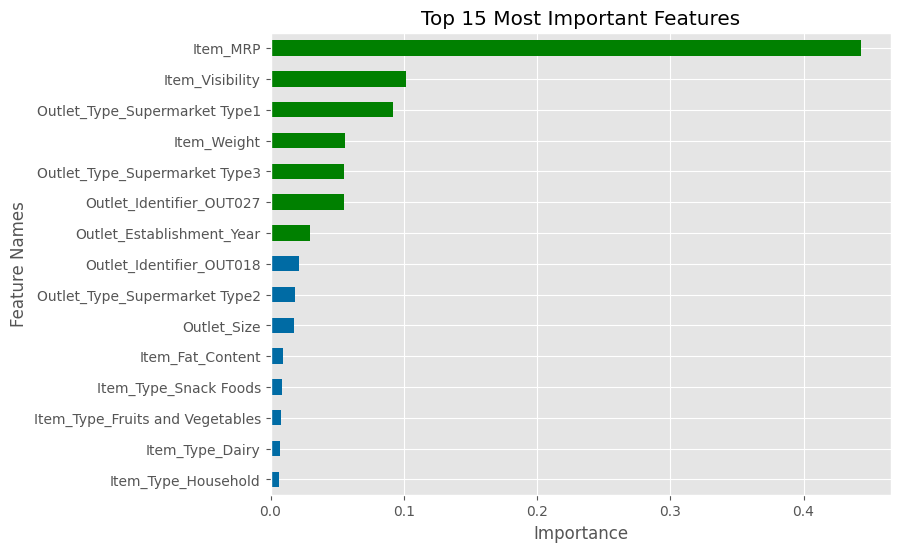

In [33]:
plot_importance_color(importances, color_dict=colors_top7,top_n=15);

#5 most important features:
- Item_MRP
- Item_Visibility
- Outlet_Type_Supermarket Type 1
- Item_Weight
- Outlet_Type_Supermarket Type 1


An "important' feature is one that was used extensively/repeatedly by the model when during the training process. Feature Importance does not indicate directionality.